In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# measurement table columns
m_columns = inspect(engine).get_columns('measurement')
for m in m_columns:
    print(m['name'], m['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
# station table columns
s_columns = inspect(engine).get_columns('station')
for s in s_columns:
    print(s['name'], s['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
final_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
final_date

'2017-08-23'

In [11]:
year_ago = dt.date(2016, 8, 23)
year_ago

datetime.date(2016, 8, 23)

In [12]:
# Perform a query to retrieve the data and precipitation scores
prcp_scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df = pd.DataFrame(prcp_scores).rename(columns = {0: "date", 1: "precipitation"}).dropna(how = 'any')
prcp_df = prcp_df.groupby("date").max()
prcp_df.head()

,precipitation
date,
2016-08-23,1.79
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18


<AxesSubplot:title={'center':'Daily Max Precipitation of Hawaii Weather Stations'}, xlabel='Date', ylabel='Inches'>

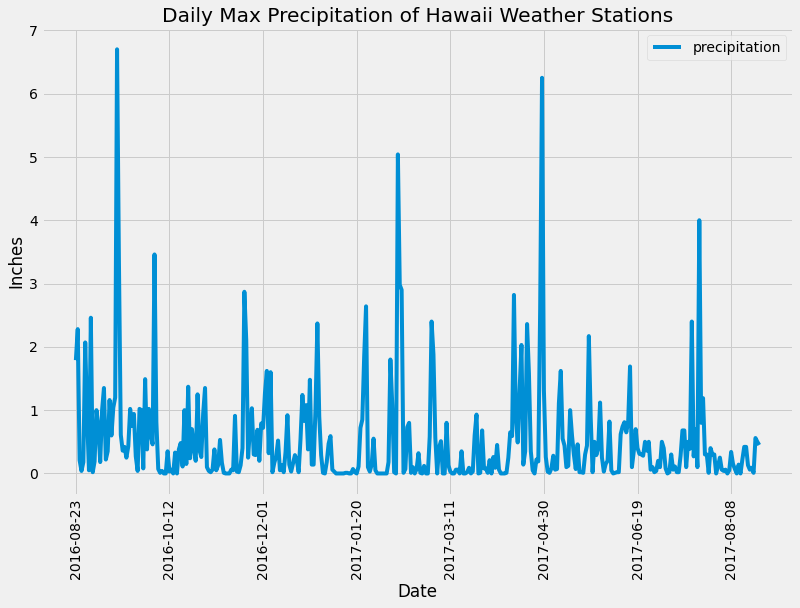

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize = (12,8),
             xlabel=("Date"),
             rot = 90,
             ylabel = ("Inches"),
             title = ("Daily Max Precipitation of Hawaii Weather Stations")            
            )

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
pd.DataFrame(prcp_scores).describe()

,1
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Sum of precpitation from all stations
# prcp_scores1 = session.query(Measurement.date, Measurement.prcp, Measurement.station).\
#     filter(Measurement.date >= year_ago).all()

# prcp_df1 = pd.DataFrame(prcp_scores1).rename(columns = {0: "date", 1: "precipitation", 2: "station"}).dropna(how = 'any')
# print(prcp_df1["station"].value_counts())
# prcp_df1 = prcp_df1.groupby('date').sum()
# prcp_df1.plot(figsize = (12,8), rot = 90)

In [17]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).\
    group_by(Measurement.station).count()

print(f"There are {station_count} stations.")

There are 9 stations.


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_rows = session.query(Measurement.station, func.count(Measurement.prcp)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.prcp).desc()).all()

station_rows

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [19]:
print(f"{station_rows[0][0]} is the most active.")

USC00519281 is the most active.


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_station = station_rows[0][0]
temp_obs = session.query(Measurement.station,
              func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs)             
             ).\
    group_by(Measurement.station).\
    filter(Measurement.station == active_station).all()

print(f"Station: {temp_obs[0][0]}")
print(f"Lowest temperature: {temp_obs[0][1]}")
print(f"Highest temperature: {temp_obs[0][2]}")
print(f"Average temperature: {temp_obs[0][3]}")

Station: USC00519281
Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 71.66378066378067


In [21]:
# Choose the station with the highest number of temperature observations.
session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date).all()
temp_data_df = pd.DataFrame(temp_data).rename(columns = {0: "date", 1: "tobs"}).set_index("date")
temp_data_df.head()

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


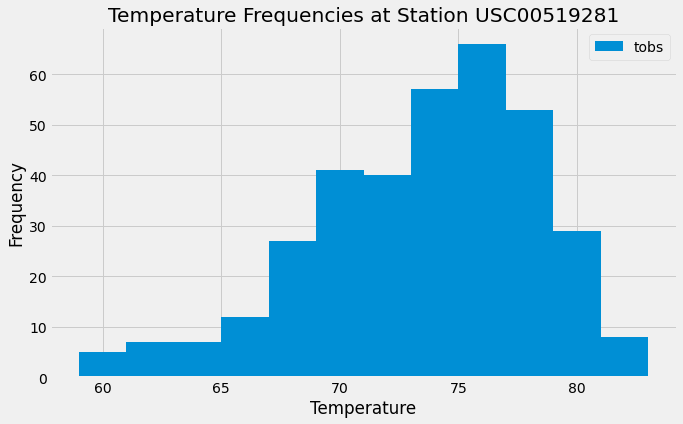

In [23]:
temp_data_df.hist(bins = 12, figsize = (10, 6), legend = True)

plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature Frequencies at Station USC00519281")
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
